<a href="https://colab.research.google.com/github/mekriti/ATM-simulator-basic-python/blob/master/Copy_of_LSTM%20ODSC%20Delhi%20Nov%2010%2C2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns


tf.random.set_seed(0)
tf.__version__

'2.0.0'

### TimeSeries form AIOPS data competition 

In [3]:
!wget https://schopra-2018.s3.ap-south-1.amazonaws.com/train.csv
!wget https://schopra-2018.s3.ap-south-1.amazonaws.com/test.csv
!ls

--2019-11-10 07:48:03--  https://schopra-2018.s3.ap-south-1.amazonaws.com/train.csv
Resolving schopra-2018.s3.ap-south-1.amazonaws.com (schopra-2018.s3.ap-south-1.amazonaws.com)... 52.219.64.99
Connecting to schopra-2018.s3.ap-south-1.amazonaws.com (schopra-2018.s3.ap-south-1.amazonaws.com)|52.219.64.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1750040 (1.7M) [text/csv]
Saving to: ‘train.csv’

train.csv           100%[===================>]   1.67M  1.18MB/s    in 1.4s    

2019-11-10 07:48:05 (1.18 MB/s) - ‘train.csv’ saved [1750040/1750040]

--2019-11-10 07:48:09--  https://schopra-2018.s3.ap-south-1.amazonaws.com/test.csv
Resolving schopra-2018.s3.ap-south-1.amazonaws.com (schopra-2018.s3.ap-south-1.amazonaws.com)... 52.219.64.103
Connecting to schopra-2018.s3.ap-south-1.amazonaws.com (schopra-2018.s3.ap-south-1.amazonaws.com)|52.219.64.103|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1163401 (1.1M) [text/csv]
Saving to: ‘t

In [4]:
train_csv_path = './train.csv'
test_csv_path = './test.csv'

df_train = pd.read_csv(train_csv_path)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88577 entries, 0 to 88576
Data columns (total 3 columns):
data         88577 non-null float64
timestamp    88577 non-null int64
label        88577 non-null int64
dtypes: float64(1), int64(2)
memory usage: 2.0 MB


In [5]:
df_test = pd.read_csv(test_csv_path)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59052 entries, 0 to 59051
Data columns (total 3 columns):
data         59052 non-null float64
timestamp    59052 non-null int64
label        59052 non-null int64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB


In [0]:
def plot_time_series(df):
    plot_data = df['data']
    plot_data.index = df['timestamp']
    plot_data.plot(subplots=True,)

### Visualize dataset

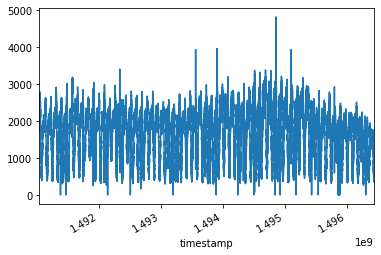

In [7]:
plot_time_series(df_train)

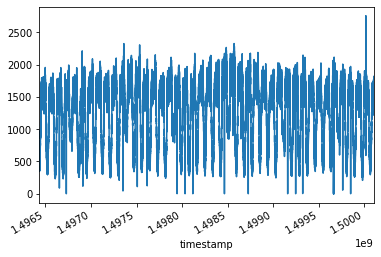

In [8]:
plot_time_series(df_test)

In [9]:
train_mean = df_train['data'].mean()
train_std = df_train['data'].std()

print("Mean is {}".format(train_mean))
print("Std is {}".format(train_std))

Mean is 1657.9532271357125
Std is 689.900535321167


In [0]:
def get_dataset(csv_path, mean, std ,window_size = 16, prediction_length = 1, batch_size = 32 ,repeat = None):
    
    dataset = tf.data.experimental.make_csv_dataset(csv_path,batch_size=1,shuffle=False,num_epochs=1)
    
    dataset = dataset.unbatch().map(lambda x : (x['data']-mean)/std)
    
    x_dataset = dataset.window(window_size, shift=1, stride=1, drop_remainder=True).flat_map(lambda x : x.batch(1).batch(window_size))

    y_dataset = dataset.skip(window_size).window(prediction_length, shift=1, stride=1, drop_remainder=True).flat_map(lambda x : x.batch(prediction_length))

    train_dataset = tf.data.Dataset.zip((x_dataset,y_dataset)).shuffle(1000).batch(batch_size).repeat(repeat).prefetch(500)
    
    return train_dataset


In [11]:
train_dataset = get_dataset(train_csv_path, train_mean,train_std, window_size = 16, prediction_length = 1, batch_size = 32, repeat = 1)

test_dataset = get_dataset(test_csv_path, train_mean, train_std, window_size = 16, prediction_length = 1, batch_size = 256 ,repeat = 1)

# (32, 16, 1)  (32, 1)

Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.


In [0]:
class RNN(tf.keras.Model):
    def __init__(self):
        super(RNN,self).__init__()
        self.lstm_layer1 = tf.keras.layers.LSTM(units = 32, activation='tanh',return_sequences=True, dropout=0.2)
        self.lstm_layer2 = tf.keras.layers.LSTM(units = 8, activation='tanh',return_sequences=False, dropout=0.2)
        self.dense = tf.keras.layers.Dense(1)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
        self.mse = tf.keras.losses.MeanSquaredError()
        
    
    def call(self, x):
#         out1 = self.lstm_layer1(x)             # 32x16x8 
#         print(out1.shape)
        out2 = self.lstm_layer2(x)             # 32x8 (batch_size x squence_length x hidden_units) (sequence_lenngth got collapsed bcz return_sequences=False)
#         print(out2.shape)
        out3 = self.dense(out2)                # 32x1 
        return out3
    
    def loss(self,x,y):
        prediction  = self.call(x)
        return self.mse(prediction,y)
    
    def train_step(self, x, y):
        
        with tf.GradientTape() as tape:
            prediction  = self.call(x)
            loss = self.mse(prediction,y)
        
        dloss_dparams = tape.gradient(loss,self.trainable_variables)
        self.optimizer.apply_gradients(zip(dloss_dparams,self.trainable_variables))
        
        return loss

In [0]:
# rnn.train_step(batch[0],batch[1]).numpy()

In [0]:
rnn = RNN()

In [0]:
num_epochs = 3
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

for epoch in range(1,num_epochs+1):
    
    #Before each epoch reset states
    train_loss.reset_states()
    test_loss.reset_states()
    
    print("######  Epoch {} started ######".format(epoch))
    for idx,batch in enumerate(train_dataset):
        loss = rnn.train_step(batch[0],batch[1])
        train_loss(loss)
    
    for idx,batch in enumerate(test_dataset):
        loss = rnn.loss(batch[0], batch[1])
        test_loss(loss)
    
    print("Training loss = {} \nTest loss = {}".format(train_loss.result(),test_loss.result()))
    print("######  Epoch {} finished  ######\n".format(epoch))
    


######  Epoch 1 started ######
Training loss = 0.10320084542036057 
Test loss = 0.014760428108274937
######  Epoch 1 finished  ######

######  Epoch 2 started ######


In [0]:
def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps


def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
            
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

In [0]:
for data in test_dataset.unbatch().take(3):
    print(data[0].shape)
    
    rnn_input = tf.reshape(data[0],(-1,16,1))
    rnn_prediction = tf.reshape(rnn(rnn_input),(1,)).numpy()
    plot = show_plot([data[0].numpy(),data[1].numpy(),rnn_prediction],0,'LSTM')
    plot.show()

## tf.data module
* very easy to build input pipelines with high throughput
* can read data directly from disk
* can read multiple files in parrallel
* transform data in parallel
* is python iterable. iterate over it using python for loops
* dataset is a collection of elemets where an element can a tensor or a dataset itself


In [0]:
# dataset of consecutive numbers 
# each element is a rank 0 tensor (scalar)
seq_dataset = tf.data.Dataset.range(50)

In [0]:
for x in seq_dataset:
    print(x.shape)
    print(x)
    break

In [0]:
def print_dataset(dataset,take=None):
    if take is None:
        for x in dataset:
            print(x.numpy())
    else:
        for x in dataset.take(take):
            print(x.numpy())

In [0]:
print_dataset(seq_dataset)

In [0]:
# .batch()
# increase the rank by 1
# add dimension on the left equal to batch_size
seq_dataset_batched = seq_dataset.batch(5,drop_remainder=True)

print_dataset(seq_dataset_batched,take = 5)


In [0]:
# .unbatch()
# decrease the rank by 1
# it will split the tensor of a dataset into multiple tensors for all elements
# a tensor (A,B,C) will give A tensors of (B,C)  
print_dataset(seq_dataset_batched.unbatch(),take = 10)

In [0]:
# .repeat()
# for multiple iterations over dataset
print_dataset(seq_dataset.repeat(2))
    

In [0]:
# .map()
# transform each element of a dataset
seq_dataset_mapped = seq_dataset.map(lambda x : x*x, num_parallel_calls=tf.data.experimental.AUTOTUNE)

print_dataset(seq_dataset_mapped,take = 5)


In [0]:
# .window()
# .flatmap()
seq_dataset_window = seq_dataset.window(size=5,shift=1,stride=1,drop_remainder=True)

for idx,x in enumerate(seq_dataset_window.take(5)):
    print(idx,x)
# .flat_map(lambda x: x)

print("\n\n\n")

In [0]:
#.window()
# combine input elements into a dataset of windows
seq_dataset_window = seq_dataset.window(size=5, shift=1, stride=1, drop_remainder=True)
for dataset in seq_dataset_window.take(5):
    print(dataset)

In [0]:
#.flat_map
print_dataset(seq_dataset_window.flat_map(lambda x : x),take=10)

In [0]:
# [1 2 3 4 5 6 7 8 9 10 .....]

# [1 2 3 4 5]
# [2 3 4 5 6]
# [3 4 5 6 7]
# [4 5 6 7 8]


seq_dataset_window_series = seq_dataset.window(size=5, shift=1, stride=1, drop_remainder=True).flat_map(lambda x : x.batch(5))
print_dataset(seq_dataset_window_series,take=5)
# seq_dataset.window(size=5, shift=1, stride=1, drop_remainder=True).flatmap(lambda x : x).batch(5)


In [0]:
# [0 1 2 3 4]  5
# [1 2 3 4 5]  6
# [2 3 4 5 6]  7
# [3 4 5 6 7]  8

seq_dataset_label = seq_dataset.skip(5)
print_dataset(seq_dataset_label,take = 5)
print("\n\n\n")
seq_dataset_zipped = tf.data.Dataset.zip((seq_dataset_window_series,seq_dataset_label))
for x in seq_dataset_zipped.take(5):
    print(x[0].numpy(),x[1].numpy())

In [0]:
# [0 1 2 3 4]  [5,6]
# [1 2 3 4 5]  [6,7]
# [2 3 4 5 6]  [7,8]
# [3 4 5 6 7]  [8,9]

seq_dataset_target = seq_dataset.skip(5).window(size=2,shift=1,stride=1).flat_map(lambda x : x.batch(2))
print_dataset(seq_dataset_target,take = 5)

seq_dataset_zipped = tf.data.Dataset.zip((seq_dataset_window_series,seq_dataset_label))

for x in seq_dataset_zipped.take(5):
    print(x[0].numpy(),x[1].numpy())

## 2) Gradient 

In [0]:
x = tf.constant(2.0)
y = tf.Variable(4.0)

with tf.GradientTape() as tape:
    tape.watch(x)
    s = x + y
    m = x*y
    ts = s + m
    

print(tape.gradient(ts,x).numpy()) ## 1 + y


In [0]:
print(tape.gradient(ts,y).numpy()) ## 1 + x

In [0]:

x = tf.constant(2.0)
y = tf.Variable(4.0)


with tf.GradientTape(persistent= True) as tape:
    tape.watch(x)
    s = x + y
    m = x*y
    ts = s + m
    

print(tape.gradient(ts,x).numpy()) ## 1 + y
print(tape.gradient(ts,y).numpy()) ## 1 + x

In [0]:
with tf.GradientTape(persistent=True) as innerTape:
    m = y * y * y
    dm_dy = innerTape.gradient(m,y)
    d2m_dy2 = innerTape.gradient(dm_dy,y)


In [0]:
with tf.GradientTape() as outerTape:
    with tf.GradientTape() as innerTape:
        m = y * y * y
    dm_dy = innerTape.gradient(m,y)

d2m_dy2 = outerTape.gradient(dm_dy,y)
print(d2m_dy2.numpy()) # 6 * y = 24